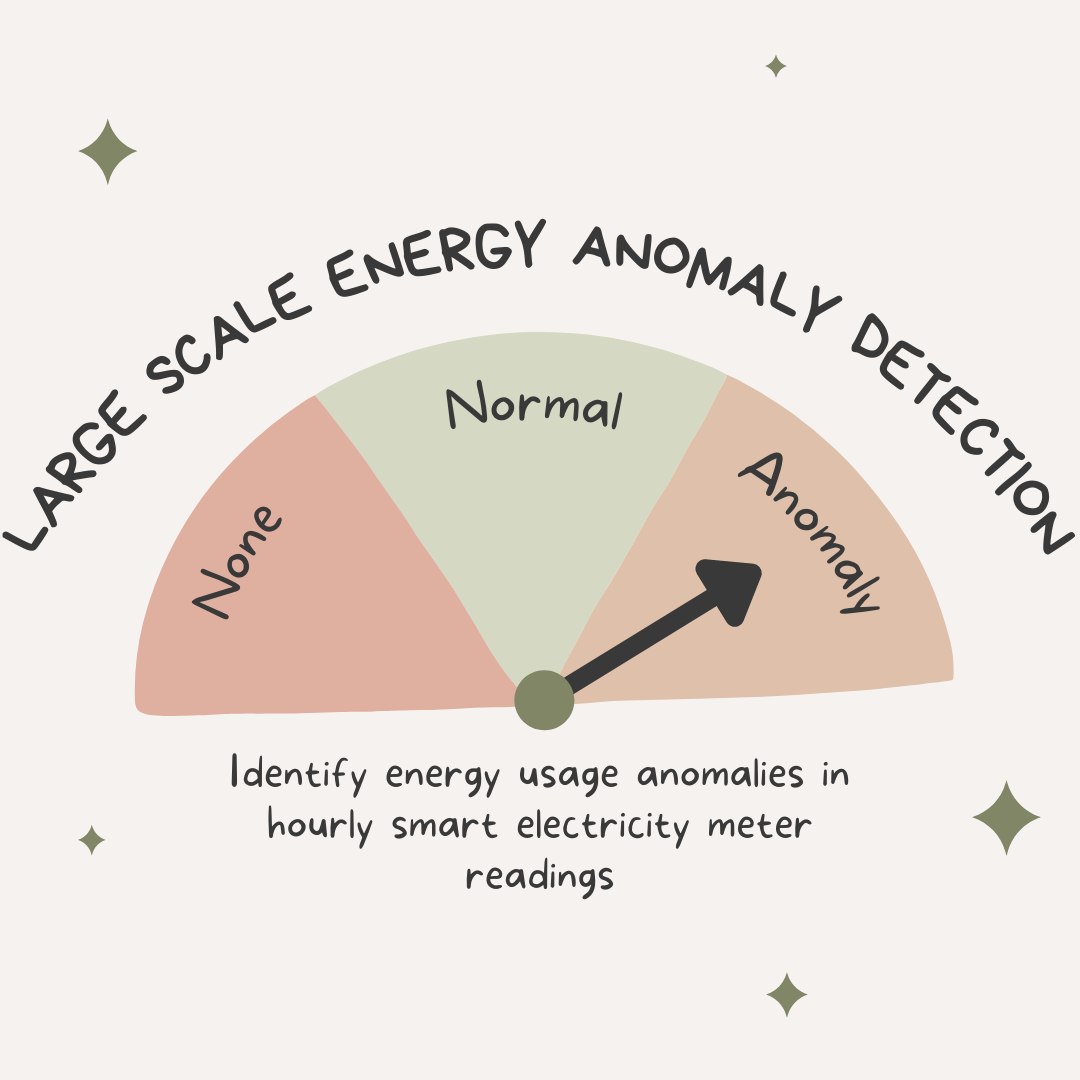

# <p style="text-align:center;font-size:150%;font-family:Roboto;background-color:#a04070;border-radius:50px;font-weight:bold;margin-bottom:0">Large Scale Energy Anomaly Detection</p>

<p style="font-family:Roboto;font-size:140%;color:#a04070;">In this Notebook, I had implemented the anomaly detection model to predict whether the energy usage in a building is anomalous or not. This will help to save a lot of energy. In this notebook I had used the <code>train_features.csv</code> data to build a model. Look at my this <a href='', target='_blank'>notebook</a> in which I had implement a model by just using the train.csv data.<p> 

<!-- <a id='top'></a> -->
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#a04070;font-family:Roboto;font-size:160%;text-align:center;border-radius:50px;">TABLE OF CONTENTS</p>   
    
* [1. Importing Libraries](#1)
    
* [2. Exploratory Data Analysis](#2)
    
* [3. Highly Correlated Features](#3)
    
* [4. Model Development](#4) 
    
* [5. The End](#5) 

<a id="1"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">IMPORTING LIBRARIES</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Exploratory Data Analysis</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">We have been provided with a whole lot of features. As per the Author of the competition data and cleaned and one can focused on the model building but till we are not sure with the features provided and what they represent how can we go forward.</p>

In [2]:
train = pd.read_csv('../input/energy-anomaly-detection/train_features.csv')
train.shape

(1749494, 57)

In [3]:
train.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


In [4]:
for col in train.columns:
    k = train[col].isnull().sum()
    if k > 0:
        print(f'{col} : {k}')

meter_reading : 107653


<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">In this data as well only <code>meter_reading</code> has null values.</p>

In [5]:
train[train['anomaly']==1].isnull().sum()

building_id                      0
timestamp                        0
meter_reading                    0
anomaly                          0
site_id                          0
primary_use                      0
square_feet                      0
year_built                       0
floor_count                      0
air_temperature                  0
cloud_coverage                   0
dew_temperature                  0
precip_depth_1_hr                0
sea_level_pressure               0
wind_direction                   0
wind_speed                       0
air_temperature_mean_lag7        0
air_temperature_max_lag7         0
air_temperature_min_lag7         0
air_temperature_std_lag7         0
air_temperature_mean_lag73       0
air_temperature_max_lag73        0
air_temperature_min_lag73        0
air_temperature_std_lag73        0
hour                             0
weekday                          0
month                            0
year                             0
weekday_hour        

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">There are no such entries where it is an anomalous case and <code>meter_reading</code> is null.</p>

In [6]:
train[train['meter_reading']==1.0]['anomaly'].value_counts()

1    17053
0        6
Name: anomaly, dtype: int64

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Very nice observation indeed has been shown in this <a href='https://www.kaggle.com/competitions/energy-anomaly-detection/discussion/326252' target='_blank'>discussion</a>.</p>

In [7]:
for idx in tqdm(train['building_id'].unique()):
    if train[train['building_id']==idx]['primary_use'].nunique()>1:
        print(idx)

100%|██████████| 200/200 [00:04<00:00, 44.89it/s]


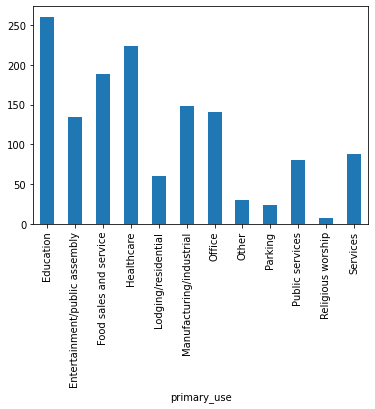

In [8]:
mean_by_use = train.groupby('primary_use').mean()['meter_reading']
mean_by_use.plot.bar()
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Each building provides only one type of facility/usecase and above chart shows the mean usage by use case throughout the year with minimum at the religious places and highest at the Education institutions.</p>
<br>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Now let's explore what are the different features has been provided in this data as compare to the train.csv.</p>

In [9]:
ints = []
objects = []
floats = []

for col in train.columns:
    if train[col].dtype == int:
        ints.append(col)
    elif train[col].dtype == object:
        objects.append(col)
    else:
        floats.append(col)

<p style="color:#cc107e;font-family:Roboto;font-size:180%;margin-bottom:0">Analysis of the columns with <code>int</code> datatype.</p>

In [10]:
ints

['building_id',
 'anomaly',
 'site_id',
 'square_feet',
 'year_built',
 'floor_count',
 'cloud_coverage',
 'precip_depth_1_hr',
 'wind_direction',
 'hour',
 'weekday',
 'month',
 'year',
 'is_holiday']

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Columns from <code>hour</code> to <code>is_holiday</code> is nothing but the expanded form of the timestamp so, we can remove that feature.</p>

In [11]:
train[ints].nunique()

building_id          200
anomaly                2
site_id               14
square_feet          200
year_built            32
floor_count           12
cloud_coverage        11
precip_depth_1_hr    128
wind_direction        44
hour                  24
weekday                7
month                 12
year                   1
is_holiday             2
dtype: int64

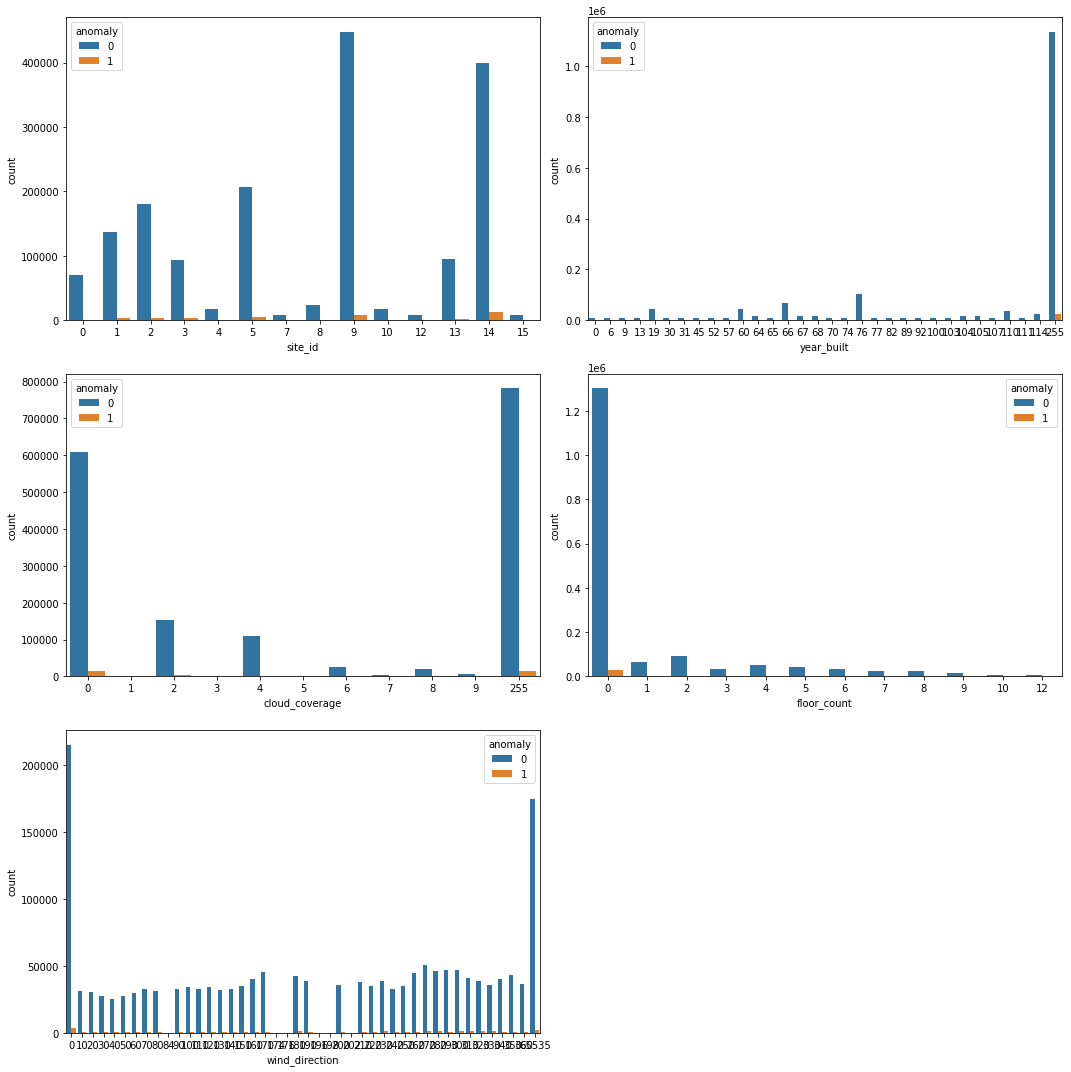

In [12]:
plt.subplots(figsize=(15,15))
sample = ['site_id', 'year_built', 'cloud_coverage', 'floor_count', 'wind_direction']

for i, col in enumerate(sample):
    plt.subplot(3,2,i+1)
    sb.countplot(train[col], hue=train['anomaly'])
plt.tight_layout()
plt.show()

In [13]:
train['year_built'].value_counts()

255    1161101
76      105408
66       70271
19       43920
60       43919
110      35058
114      26345
105      17568
104      17568
68       17567
67       17566
64       17564
9         8784
77        8784
13        8784
45        8784
100       8784
74        8784
0         8784
6         8784
107       8784
103       8784
111       8784
31        8783
89        8783
70        8782
82        8782
57        8781
65        8781
92        8781
52        8781
30        8761
Name: year_built, dtype: int64

In [15]:
train['cloud_coverage'].value_counts()

255    797545
0      622994
2      155730
4      111173
6       26337
8       22152
9        8231
7        3485
1         713
3         608
5         526
Name: cloud_coverage, dtype: int64

<ul style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0"><li><code>year_built</code> - To get the exact <code>year_built</code> add <code>1900</code> to the same </li><li><code>cloud_coverage</code> - It has all values from <code>0 - 9</code>. But the value <code>255</code> in both <code>year_built</code> and <code>cloud_coverage</code> are replacement for the null values.</li></ul>

In [16]:
train['cloud_coverage'] = train['cloud_coverage'].replace({255:10})
train.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


In [17]:
for col in train.columns:
    if train[col].nunique()==1:
        print(col, train[col].dtype)

year int64
gte_meter float64



<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">No use of columns in the modelling with only one values for all the entries.</p>

In [18]:
train = train.drop(['timestamp', 'year', 'gte_meter'], axis=1)

<p style="color:#cc107e;font-family:Roboto;font-size:180%;margin-bottom:0">Analysis of the columns with <code>object</code> datatype.</p>

In [19]:
objects

['timestamp',
 'primary_use',
 'weekday_hour',
 'building_weekday_hour',
 'building_weekday',
 'building_month',
 'building_hour',
 'building_meter']

In [20]:
train['building_month'].unique()

array(['1-0-1', '32-0-1', '41-0-1', ..., '1353-0-12', '827-0-12',
       '848-0-12'], dtype=object)

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">It seems like these features are nothing but the concatenation of the <code>building_id</code> with the <code>month</code>, <code>hour</code> or other time realted features. In my opinion these are not going to help us as none of the values will overlap with the test data as the building id's are totally different for the test data set. So, the distribution of the data will vary.</p>

In [21]:
train = train.drop(objects[2:], axis=1)
print(train.shape)

(1749494, 48)


<p style="color:#cc107e;font-family:Roboto;font-size:180%;margin-bottom:0">Analysis of the columns with <code>float</code> datatype.</p>

In [22]:
floats

['meter_reading',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_speed',
 'air_temperature_mean_lag7',
 'air_temperature_max_lag7',
 'air_temperature_min_lag7',
 'air_temperature_std_lag7',
 'air_temperature_mean_lag73',
 'air_temperature_max_lag73',
 'air_temperature_min_lag73',
 'air_temperature_std_lag73',
 'hour_x',
 'hour_y',
 'month_x',
 'month_y',
 'weekday_x',
 'weekday_y',
 'gte_hour',
 'gte_weekday',
 'gte_month',
 'gte_building_id',
 'gte_primary_use',
 'gte_site_id',
 'gte_meter',
 'gte_meter_hour',
 'gte_meter_weekday',
 'gte_meter_month',
 'gte_meter_building_id',
 'gte_meter_primary_use',
 'gte_meter_site_id',
 'gte_meter_building_id_hour',
 'gte_meter_building_id_weekday',
 'gte_meter_building_id_month']

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">These features from it's name seems like they are derived by feature engineering from the time and the <code>building_id</code> except for some columns let's keep them as of now. It has been given in the data section that these features has been used by the winners so, may be these features proved to be helpful.</p>

In [23]:
def impute_nulls(data):
    mean_reading = data.groupby('building_id').mean()['meter_reading']

    building_id = mean_reading.index
    values = mean_reading.values
    
    for i, idx in tqdm(enumerate(building_id)):
        data[data['building_id']==idx] = data[data['building_id']==idx].fillna(values[i]) 
    
    return data

train = impute_nulls(train)

200it [01:57,  1.70it/s]


<a id="3"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Highly Correlated Features</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">By the name of the columns it is clear that they have been derived by combining two or more succint features. In such cases there is possibility of having high correlation between the developed feature and the original feature. And as much as I know highly correlated features doesn't help model.</p>

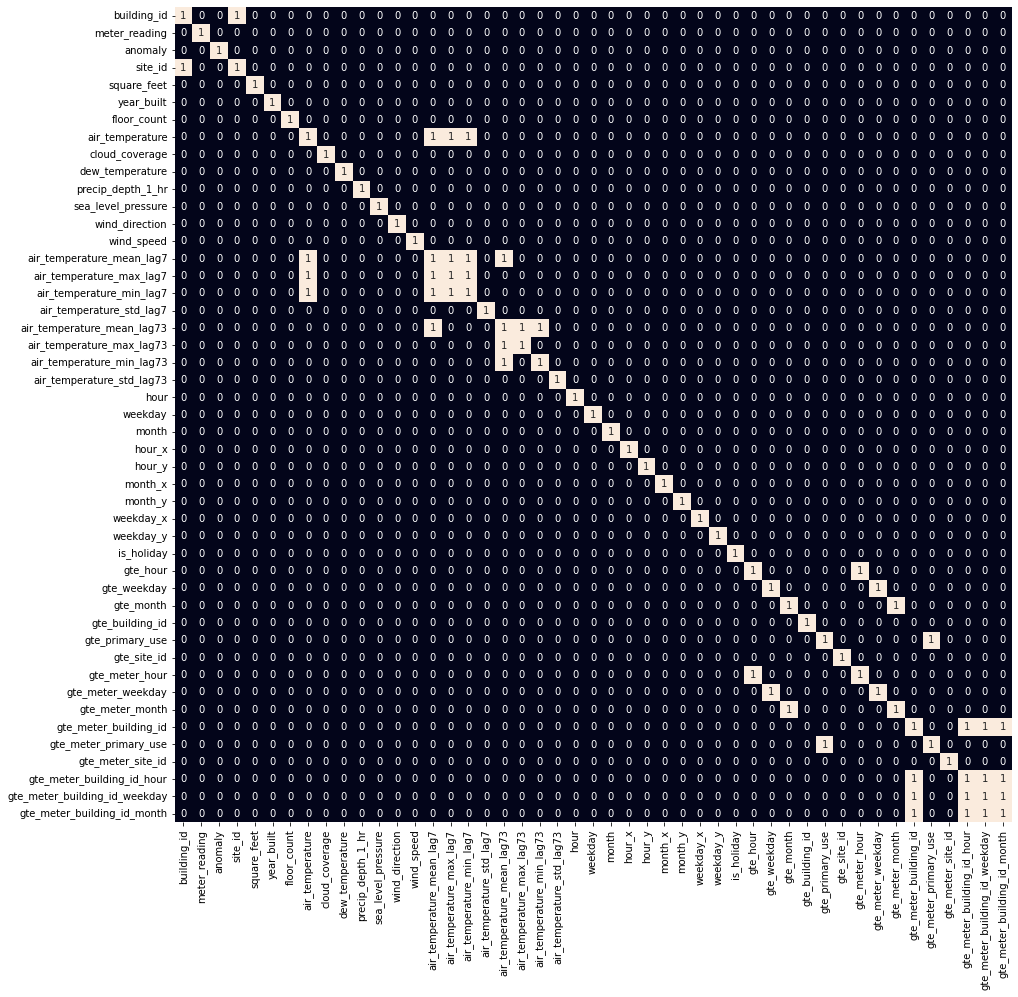

In [24]:
plt.figure(figsize=(15,15))
sb.heatmap(train.corr() > 0.95, annot=True, cbar=False)
plt.show()

In [26]:
hcorr = [ 'building_id',
         'site_id',
 'gte_meter_hour',
 'gte_meter_weekday',
 'gte_meter_month',
 'gte_meter_building_id',
 'gte_meter_primary_use',
 'gte_meter_site_id',
 'gte_meter_building_id_hour',
 'gte_meter_building_id_weekday',
 'gte_meter_building_id_month',
 'air_temperature_mean_lag73',
 'air_temperature_max_lag73',
 'air_temperature_min_lag73',
 'air_temperature_mean_lag7',
 'air_temperature_max_lag7',
 'air_temperature_min_lag7']

train = train.drop(hcorr, axis=1)
train.shape

(1749494, 32)

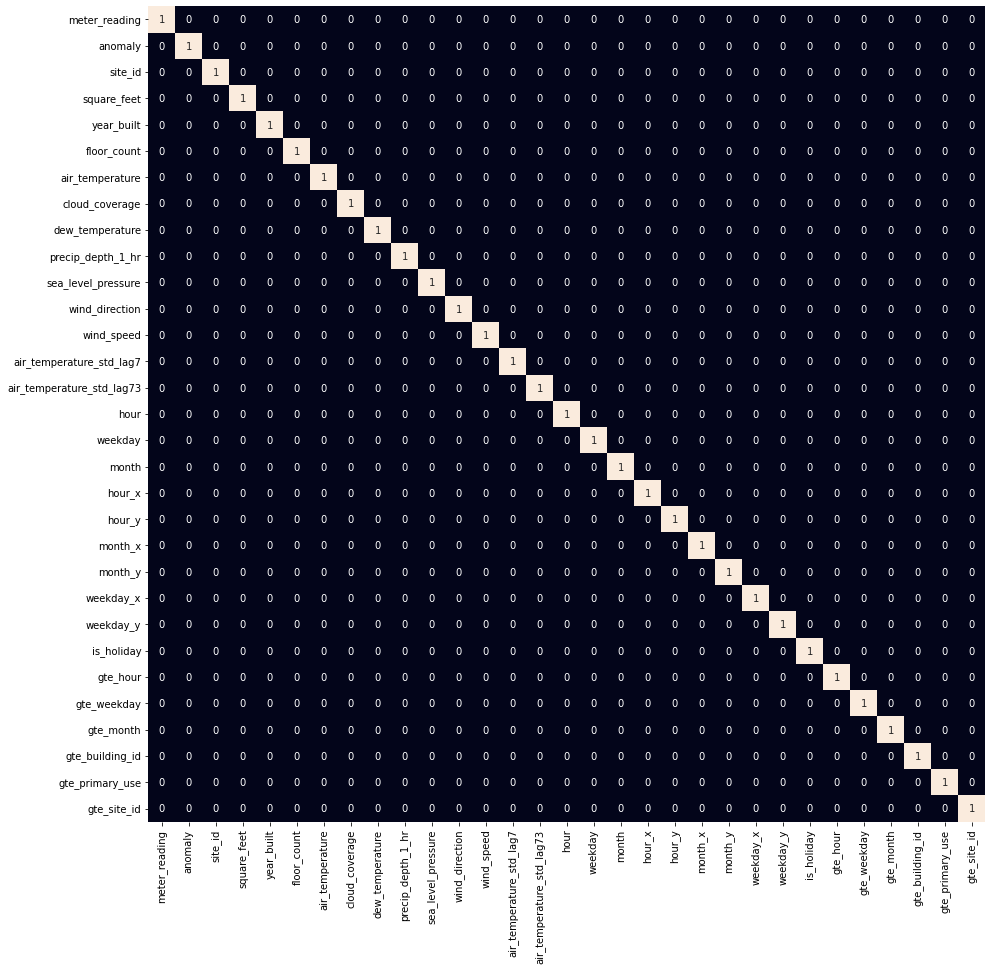

In [27]:
plt.figure(figsize=(15,15))
sb.heatmap(train.corr() > 0.75, annot=True, cbar=False)
plt.show()

<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Now, there are no highly correlated features and we are good to go and build our anomaly detection model.</p>

<a id="4"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">Model Development</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">Training an XGBClassifier on millions of rows take hell lot of time that is why I have implemented a neural network model so, that the model can go through all the examples in feasible time. By using the RandomOverSampler I had balanced the negative and the positive exmaples so, that model can perform well for the negative as well as positive examples.</p>

In [29]:
test = pd.read_csv('../input/energy-anomaly-detection/test_features.csv', index_col=0)
test = impute_nulls(test)
test['cloud_coverage'] = test['cloud_coverage'].replace({255:10})
test = test.drop(['timestamp', 'year', 'gte_meter'] + objects[2:] + hcorr, axis=1)

206it [03:07,  1.10it/s]


In [30]:
set1 = set(train['primary_use'].unique())
set2 = set(test['primary_use'].unique())
combined = list(set1.union(set2))

In [31]:
le = LabelEncoder()
le.fit(combined)
train['primary_use'] = le.transform(train['primary_use'])
test['primary_use'] = le.transform(test['primary_use'])

In [32]:
print(train.shape, test.shape)

(1749494, 32) (1800567, 31)


In [33]:
neg = train[train['anomaly'] == 0]
pos = train[train['anomaly'] == 1]

print(neg.shape, pos.shape)
negs1 = neg.sample(n = 37296, random_state=10)
negs2 = neg.sample(n = 37296, random_state=20)
df_eq = pd.concat([negs1, pos, negs2, pos], axis=0)
print(df_eq.shape)

(1712198, 32) (37296, 32)
(149184, 32)


In [34]:
features = df_eq.drop(['anomaly'], axis=1)
target = df_eq['anomaly']

In [35]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.01, random_state=10)
print(X_train.shape, X_val.shape)

(147692, 31) (1492, 31)


In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test1 = scaler.transform(test)

In [37]:
models = [LogisticRegression(), XGBClassifier()]

for i in range(2):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, models[i].predict_proba(X_val)[:,1]))
    print()

LogisticRegression() : 
Training Accuracy :  0.6413705785011297
Validation Accuracy :  0.647692896699362

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) : 
Training Accuracy :  0.9948881912019057
Validation Accuracy :  0.9947083385009715



<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">As compare to the model which I build by just using the <code>train.csv</code> I achieved around <code>95%</code> validation accuracy and now <code>99%</code> which means that the presence of the extra features has certainly helped to improve the performance of the model.</p>

In [38]:
predictions = models[1].predict_proba(test1)[:,1]

In [39]:
ss = pd.read_csv('../input/energy-anomaly-detection/sample_submission.csv')
ss['anomaly'] = predictions
ss.to_csv('Submission_xgb.csv', index=False)
ss.head()

,row_id,anomaly
0,0,0.061411
1,1,0.245588
2,2,0.103897
3,3,0.174742
4,4,0.047582


In [40]:
features = train.drop(['anomaly'], axis=1)
target = train['anomaly']

In [41]:
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size = 0.05, random_state=10)
print(X_train.shape, X_val.shape)

(1662019, 31) (87475, 31)


In [42]:
ros = RandomOverSampler(sampling_strategy='minority',random_state=5)
X, Y = ros.fit_resample(X_train,Y_train)

In [43]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)
test2 = scaler.transform(test)

In [44]:
model = keras.Sequential([
  layers.Input(shape=(31,)),

  layers.Dense(256, activation='relu'),
  layers.BatchNormalization(),
    
  layers.Dense(256, activation='relu'),
  layers.BatchNormalization(),

  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),

  layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics = ['AUC']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               8192      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

2022-05-23 07:41:26.935147: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [45]:
history = model.fit(X, Y,
                    verbose = 1,
                    batch_size = 128,
                    epochs = 1,
                    validation_data = (X_val, Y_val))

2022-05-23 07:41:28.152576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


25415/25415 [==============================] - 150s 6ms/step - loss: 0.1328 - auc: 0.9889 - val_loss: 0.0849 - val_auc: 0.9909


<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0">By considering the amount of the data we have one-shot learning is enough.</p>

In [46]:
predictions = model.predict(test2)

In [47]:
ss = pd.read_csv('../input/energy-anomaly-detection/sample_submission.csv')
ss['anomaly'] = predictions
ss.to_csv('Submission_nn.csv', index=False)
ss.head()

,row_id,anomaly
0,0,5.507032e-08
1,1,8.027926e-05
2,2,9.786551e-05
3,3,5.129314e-05
4,4,1.095688e-04


<a id="5"></a>
# <p style="background-color:#a04070;font-family:Roboto;font-size:120%;text-align:center;border-radius:50px;margin-bottom:0">The End</p>
<p style="color:#a04070;font-family:Roboto;font-size:140%;margin-bottom:0"><code>1.</code> I had tried very less models only LogisticRegression, XGB and a Neural Net may be models like LightGBM or AutoML can help to achieve even better score so, this is still a work in progress I will update if my score improve further.<br><code>2.</code> Even after neural network has gone through all the data and was showing same performance as that of the XGB Classifier it's predictions scores less on the test data as compared to the XGB midel.</p>